# Portfolio Optimization with Markowitz Mean-Variance and ESG Control

This notebook demonstrates portfolio optimization using:
- **Expected returns** from Extended CAPM with ESG factor
- **Shrinkage covariance** estimation (Ledoit-Wolf)
- **ESG exposure constraints** (beta-based)
- **Position size limits** and sector concentration controls

## Optimization Objective

$$\max_{w} \quad \mu' w - \frac{1}{2} \gamma w' \Sigma w$$

Subject to:
- Budget constraint: $\sum_i w_i = 1$
- Long-only: $w_i \geq 0$
- Position limits: $w_i \leq w_{max}$
- ESG neutrality: $L_{ESG} \leq \sum_i \beta_i^{ESG} w_i \leq U_{ESG}$

Where:
- $w$ = portfolio weights
- $\mu$ = expected returns (from Extended CAPM)
- $\Sigma$ = covariance matrix (shrinkage estimator)
- $\gamma$ = risk aversion parameter
- $\beta^{ESG}$ = ESG factor exposures

## Expected Returns Methodology Updates

**November 2025: Implemented Sample Period Bias Corrections**

To address unrealistically high expected returns (mean 22.6% annual) caused by short sample period (2016-2024), we implemented two methodological improvements:

1. **Factor Premia Shrinkage (Option 2):**
   - Blend sample estimates with long-term historical mean
   - Formula: $\lambda_{adjusted} = w \times \lambda_{historical} + (1-w) \times \lambda_{sample}$
   - Default: w=0.5 (50/50 blend)
   - Result: Market premium 13.96% → 9.98% annual

2. **Beta Capping/Winsorization (Option 3):**
   - Cap extreme betas: $\beta_{market} \in [-3, 3]$, $\beta_{ESG} \in [-5, 5]$
   - Prevents outlier leverage (e.g., SBNY had $\beta_{ESG}=-7.69$)
   - Result: Max ER reduced from 123.8% to 58.1% annual

**Impact:** Mean expected return now 14.2% annual (vs 22.6% before), with more realistic Sharpe ratios (~1.0-1.5 annual vs 3.0+ before).

**Configuration:** Adjustable via `config/settings.yaml`

**Data Freshness:**
All programs (`two_factor_regression.py`, `extend_capm.py`, `optimize_portfolio.py`) automatically clean existing result files before generating new ones, ensuring fresh, clean data on each run.

**References:**
- Markowitz (1952): Portfolio Selection
- Ledoit & Wolf (2003): Honey, I Shrunk the Sample Covariance Matrix
- James & Stein (1961): Estimation with Quadratic Loss
- See `SHARPE_RATIO_FIX_SUMMARY.md` for detailed methodology

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Import optimization functions
from programs.optimize_portfolio import (
    load_expected_returns,
    load_esg_betas,
    load_returns_panel,
    build_shrinkage_cov,
    optimize_markowitz_esg,
    evaluate_portfolio,
    efficient_frontier_esg,
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)
pd.options.display.float_format = '{:.6f}'.format

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports successful")
print(f"Project root: {Path.cwd().parent}")

✅ Imports successful
Project root: /Users/frank/Projects/QuantX/quantx-data-builder


## 2. Load Data

Load all required inputs for portfolio optimization:
- Expected returns (from Extended CAPM)
- ESG betas (from two-factor regression)
- Historical returns (for covariance estimation)

In [2]:
# Configuration
data_root = Path.cwd().parent / "data"
lookback_months = 24
shrinkage = 0.25

# Load continuous ESG tickers
continuous_file = Path.cwd().parent / "data" / "continuous_esg_tickers.txt"
with open(continuous_file) as f:
    tickers = [line.strip() for line in f]

print(f"Universe: {len(tickers)} tickers with continuous ESG data")
print(f"Data root: {data_root}")
print(f"Lookback: {lookback_months} months")
print(f"Shrinkage: {shrinkage}")

Universe: 427 tickers with continuous ESG data
Data root: /Users/frank/Projects/QuantX/quantx-data-builder/data
Lookback: 24 months
Shrinkage: 0.25


### 2.1 Risk-Free Rate

Load the current risk-free rate for Sharpe ratio calculation.

In [3]:
# Load risk-free rate
rf_file = data_root / "curated" / "references" / "risk_free_rate" / "freq=monthly" / "3month_monthly.parquet"
rf_data = pd.read_parquet(rf_file)
latest_rf_annual = rf_data.iloc[-1]["rate"]  # Annual percentage
rf_monthly = latest_rf_annual / 12 / 100  # Convert to monthly decimal

print(f"✅ Loaded risk-free rate")
print(f"  Latest annual rate: {latest_rf_annual:.2f}%")
print(f"  Monthly equivalent: {rf_monthly:.6f} ({rf_monthly*100:.4f}%)")

✅ Loaded risk-free rate
  Latest annual rate: 4.37%
  Monthly equivalent: 0.003642 (0.3642%)


### 2.2 Expected Returns

In [4]:
# Load expected returns (latest date)
exp_ret = load_expected_returns(data_root, date=None)
exp_ret = exp_ret[exp_ret.index.isin(tickers)]

print(f"✅ Loaded expected returns for {len(exp_ret)} tickers")
print(f"\nSummary Statistics (Monthly):")
print(f"  Mean:   {exp_ret.mean():.6f} ({exp_ret.mean()*12*100:.2f}% annual)")
print(f"  Median: {exp_ret.median():.6f} ({exp_ret.median()*12*100:.2f}% annual)")
print(f"  Std:    {exp_ret.std():.6f}")
print(f"  Min:    {exp_ret.min():.6f} ({exp_ret.min()*12*100:.2f}% annual)")
print(f"  Max:    {exp_ret.max():.6f} ({exp_ret.max()*12*100:.2f}% annual)")

print(f"\nTop 10 Expected Returns:")
print((exp_ret.nlargest(10) * 12 * 100).to_frame('Annual %'))

2025-11-26 05:57:31,692 - INFO - Loaded expected returns for 419 tickers (date: 2024-12-31 00:00:00)


✅ Loaded expected returns for 419 tickers

Summary Statistics (Monthly):
  Mean:   0.012960 (15.55% annual)
  Median: 0.012514 (15.02% annual)
  Std:    0.004048
  Min:    0.003072 (3.69% annual)
  Max:    0.037880 (45.46% annual)

Top 10 Expected Returns:
        Annual %
ticker          
SBNY   45.456124
COTY   36.015733
MRNA   34.434670
PLTR   33.217941
GME    32.436032
CZR    31.782535
CLF    29.699334
PVH    28.336639
WDC    25.301424
NUE    25.092362


### 2.3 ESG Betas

2025-11-26 05:57:33,662 - INFO - Loaded ESG betas for 419 tickers


✅ Loaded ESG betas for 419 tickers

ESG Beta Statistics:
  Mean:   -0.127422
  Median: 0.037829
  Std:    1.229151
  Min:    -8.518232
  Max:    2.400224


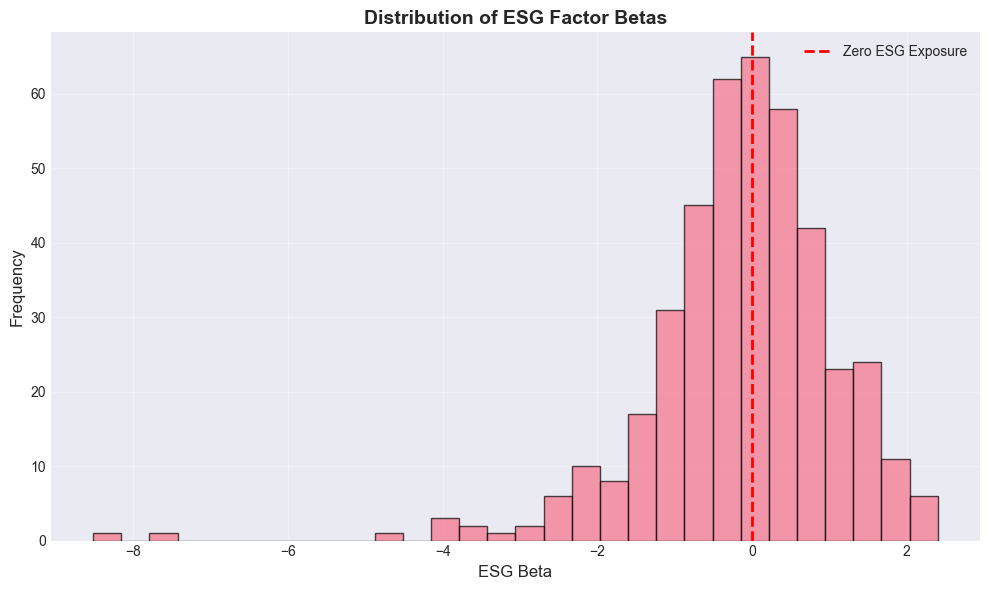

In [5]:
# Load ESG betas
esg_beta = load_esg_betas(data_root, tickers)

# Align with expected returns
common_tickers = exp_ret.index.intersection(esg_beta.index).tolist()
exp_ret = exp_ret.loc[common_tickers]
esg_beta = esg_beta.loc[common_tickers]

print(f"✅ Loaded ESG betas for {len(esg_beta)} tickers")
print(f"\nESG Beta Statistics:")
print(f"  Mean:   {esg_beta.mean():.6f}")
print(f"  Median: {esg_beta.median():.6f}")
print(f"  Std:    {esg_beta.std():.6f}")
print(f"  Min:    {esg_beta.min():.6f}")
print(f"  Max:    {esg_beta.max():.6f}")

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(esg_beta, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero ESG Exposure')
ax.set_xlabel('ESG Beta', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of ESG Factor Betas', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.4 Historical Returns and Covariance Matrix

In [6]:
# Calculate date range for lookback
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")
start_date = (pd.Timestamp.today() - pd.DateOffset(months=lookback_months)).strftime("%Y-%m-%d")

print(f"Loading returns from {start_date} to {end_date}")

# Load returns panel
returns_panel = load_returns_panel(
    data_root=data_root,
    tickers=common_tickers,
    start_date=start_date,
    end_date=end_date,
    frequency="monthly",
)

print(f"✅ Loaded {len(returns_panel)} return observations")

# Build shrinkage covariance matrix
Sigma = build_shrinkage_cov(returns_panel, col="excess", shrink=shrinkage)

print(f"✅ Built covariance matrix: {Sigma.shape[0]} x {Sigma.shape[1]}")

# Align all inputs
final_tickers = exp_ret.index.intersection(Sigma.index).tolist()
exp_ret_final = exp_ret.loc[final_tickers]
esg_beta_final = esg_beta.loc[final_tickers]
Sigma_final = Sigma.loc[final_tickers, final_tickers]

print(f"\nFinal universe: {len(final_tickers)} tickers")

2025-11-26 05:57:33,978 - INFO - Loading risk-free rate from cache: /Users/frank/Projects/QuantX/quantx-data-builder/data/curated/references/risk_free_rate/freq=monthly/3month_monthly.parquet
2025-11-26 05:57:33,994 - INFO - Loaded 14 cached observations
2025-11-26 05:57:33,994 - INFO - Loaded 14 cached observations


Loading returns from 2023-11-26 to 2025-11-26


2025-11-26 05:57:59,451 - INFO - Loaded returns panel: 3352 observations
2025-11-26 05:57:59,452 - INFO -   Tickers: 419
2025-11-26 05:57:59,454 - INFO -   Date range: 2024-01-31 00:00:00 to 2024-12-31 00:00:00
2025-11-26 05:57:59,452 - INFO -   Tickers: 419
2025-11-26 05:57:59,454 - INFO -   Date range: 2024-01-31 00:00:00 to 2024-12-31 00:00:00
2025-11-26 05:57:59,483 - INFO - Built shrinkage covariance matrix: 419 assets, shrinkage=0.25
2025-11-26 05:57:59,484 - INFO -   Min eigenvalue: 0.000202, Max: 1.150336
2025-11-26 05:57:59,483 - INFO - Built shrinkage covariance matrix: 419 assets, shrinkage=0.25
2025-11-26 05:57:59,484 - INFO -   Min eigenvalue: 0.000202, Max: 1.150336


✅ Loaded 3352 return observations
✅ Built covariance matrix: 419 x 419

Final universe: 419 tickers


## 3. Single Portfolio Optimization

Optimize a single portfolio with specific risk aversion (γ=4.0) and ESG-neutral constraints.

In [7]:
# Optimization parameters
gamma = 4.0           # Risk aversion
w_max = 0.05          # Maximum 5% per position
esg_bounds = (-0.05, 0.05)  # ESG-neutral: -5% to +5%

print(f"Optimization Parameters:")
print(f"  Risk Aversion (γ): {gamma}")
print(f"  Max Position:      {w_max*100:.1f}%")
print(f"  ESG Bounds:        [{esg_bounds[0]:.3f}, {esg_bounds[1]:.3f}]")

# Optimize
weights = optimize_markowitz_esg(
    exp_ret=exp_ret_final,
    Sigma=Sigma_final,
    esg_beta=esg_beta_final,
    gamma=gamma,
    long_only=True,
    w_max=w_max,
    esg_bounds=esg_bounds,
    solver="ECOS",
)

print(f"\n✅ Optimization complete!")
print(f"Active positions: {(weights.abs() > 1e-6).sum()}")

Optimization Parameters:
  Risk Aversion (γ): 4.0
  Max Position:      5.0%
  ESG Bounds:        [-0.050, 0.050]


2025-11-26 05:58:06,021 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:58:06,022 - INFO -   Objective value: 0.017287
2025-11-26 05:58:06,023 - INFO -   Active positions: 28
2025-11-26 05:58:06,022 - INFO -   Objective value: 0.017287
2025-11-26 05:58:06,023 - INFO -   Active positions: 28



✅ Optimization complete!
Active positions: 28


### 3.1 Portfolio Statistics

In [8]:
# Evaluate portfolio
stats = evaluate_portfolio(weights, exp_ret_final, Sigma_final, esg_beta_final, rf_month=rf_monthly)

print("=" * 70)
print("OPTIMAL PORTFOLIO STATISTICS")
print("=" * 70)
print(f"\nExpected Return:")
print(f"  Monthly:  {stats['expected_return_month']:.6f} ({stats['expected_return_month']*100:.2f}%)")
print(f"  Annual:   {stats['expected_return_ann']:.6f} ({stats['expected_return_ann']*100:.2f}%)")

print(f"\nVolatility (Risk):")
print(f"  Monthly:  {stats['vol_month']:.6f} ({stats['vol_month']*100:.2f}%)")
print(f"  Annual:   {stats['vol_ann']:.6f} ({stats['vol_ann']*100:.2f}%)")

print(f"\nRisk-Adjusted Performance:")
print(f"  Sharpe Ratio (monthly): {stats['sharpe_month']:.4f}")
print(f"  Sharpe Ratio (annual):  {stats['sharpe_month'] * np.sqrt(12):.4f}")

print(f"\nESG Exposure:")
print(f"  Portfolio β_ESG: {stats['esg_exposure']:.6f}")

print(f"\nConcentration:")
print(f"  Active positions: {(weights > 1e-6).sum()}")
print(f"  Top 5 weight:     {weights.nlargest(5).sum()*100:.2f}%")
print(f"  Top 10 weight:    {weights.nlargest(10).sum()*100:.2f}%")
print(f"  Top 20 weight:    {weights.nlargest(20).sum()*100:.2f}%")

OPTIMAL PORTFOLIO STATISTICS

Expected Return:
  Monthly:  0.018288 (1.83%)
  Annual:   0.219453 (21.95%)

Volatility (Risk):
  Monthly:  0.022368 (2.24%)
  Annual:   0.077486 (7.75%)

Risk-Adjusted Performance:
  Sharpe Ratio (monthly): 0.6548
  Sharpe Ratio (annual):  2.2682

ESG Exposure:
  Portfolio β_ESG: -0.050000

Concentration:
  Active positions: 28
  Top 5 weight:     25.00%
  Top 10 weight:    50.00%
  Top 20 weight:    90.93%


### 3.2 Top Holdings

TOP 20 HOLDINGS
     Weight  Expected Return (Annual %)  ESG Beta
0  5.000000                   19.765163  0.498216
1  5.000000                   36.015733 -4.018966
2  5.000000                   19.277084  0.851229
3  5.000000                   17.395790  1.449945
4  5.000000                   17.047016  0.758376
5  5.000000                   18.580370  2.259794
6  5.000000                   16.394358  0.140358
7  5.000000                   18.391979  1.074918
8  5.000000                   25.301424 -1.089228
9  5.000000                   29.699334 -0.408466
10 5.000000                   19.840886  0.807027
11 5.000000                   20.547295  0.619699
12 5.000000                   18.228484  1.005321
13 5.000000                   18.850659  0.325953
14 4.436105                   17.385886  0.538685
15 4.010561                   21.955108  0.296214
16 3.616383                   17.342241  0.464840
17 3.321904                   34.434670 -3.570652
18 2.830845                   22.3

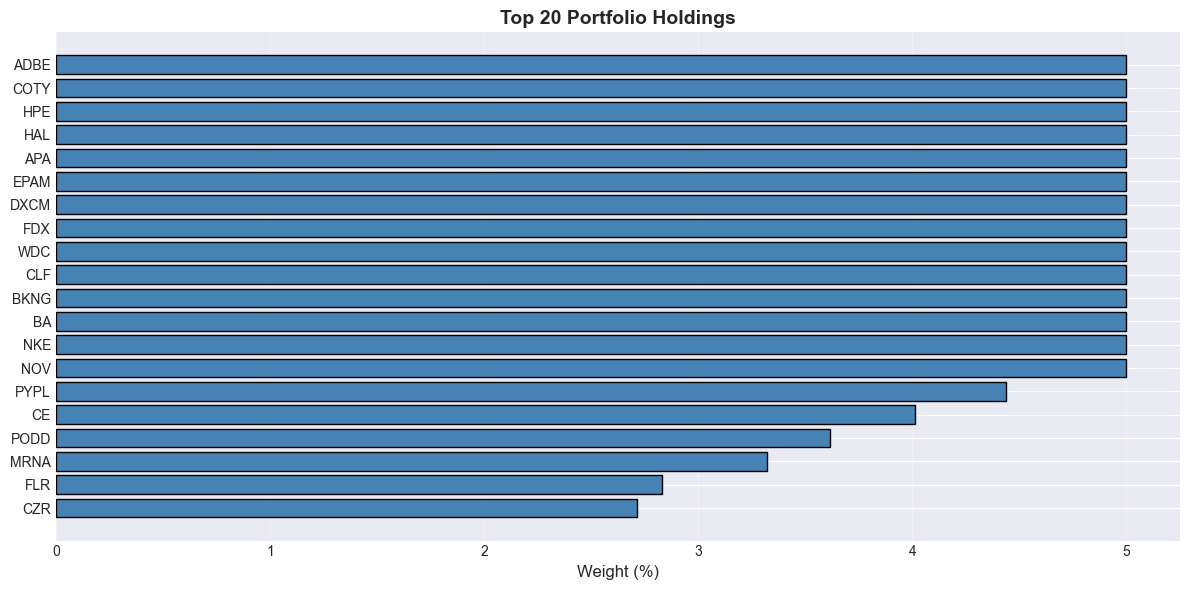

In [9]:
# Display top holdings with details
top_holdings = weights[weights > 1e-6].sort_values(ascending=False).head(20)

holdings_df = pd.DataFrame({
    'Weight': top_holdings.values * 100,
    'Expected Return (Annual %)': exp_ret_final.loc[top_holdings.index].values * 12 * 100,
    'ESG Beta': esg_beta_final.loc[top_holdings.index].values,
})

print("=" * 70)
print("TOP 20 HOLDINGS")
print("=" * 70)
print(holdings_df.to_string())

# Visualize top holdings
fig, ax = plt.subplots(figsize=(12, 6))
top_holdings_pct = top_holdings * 100
ax.barh(range(len(top_holdings_pct)), top_holdings_pct, color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_holdings_pct)))
ax.set_yticklabels(top_holdings_pct.index)
ax.set_xlabel('Weight (%)', fontsize=12)
ax.set_title('Top 20 Portfolio Holdings', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Efficient Frontier

Compute the efficient frontier by solving for multiple risk aversion levels (γ).

In [10]:
# Compute efficient frontier
gammas = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0]

print(f"Computing efficient frontier for {len(gammas)} risk aversion levels...")
print(f"Gammas: {gammas}")

frontier_df, weights_map = efficient_frontier_esg(
    exp_ret=exp_ret_final,
    Sigma=Sigma_final,
    esg_beta=esg_beta_final,
    gammas=gammas,
    long_only=True,
    w_max=w_max,
    esg_bounds=esg_bounds,
    solver="ECOS",
    rf_month=rf_monthly,
)

print("\n✅ Efficient frontier computed!")
print("\n" + "=" * 70)
print("EFFICIENT FRONTIER")
print("=" * 70)
print(frontier_df.to_string())

Computing efficient frontier for 8 risk aversion levels...
Gammas: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0]


2025-11-26 05:58:11,339 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:58:11,340 - INFO -   Objective value: 0.018655
2025-11-26 05:58:11,341 - INFO -   Active positions: 27
2025-11-26 05:58:11,340 - INFO -   Objective value: 0.018655
2025-11-26 05:58:11,341 - INFO -   Active positions: 27
2025-11-26 05:58:16,423 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:58:16,424 - INFO -   Objective value: 0.017981
2025-11-26 05:58:16,425 - INFO -   Active positions: 27
2025-11-26 05:58:16,423 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:58:16,424 - INFO -   Objective value: 0.017981
2025-11-26 05:58:16,425 - INFO -   Active positions: 27
2025-11-26 05:58:21,420 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:58:21,421 - INFO -   Objective value: 0.017567
2025-11-26 05:58:21,422 - INFO -   Active positions: 30
2025-11-26 05:58:21,420 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:58:21,421 - INFO -   Objective value: 0.017567
2025-11-2


✅ Efficient frontier computed!

EFFICIENT FRONTIER
           expected_return_month  expected_return_ann  vol_month  vol_ann  sharpe_month  esg_exposure
gamma                                                                                                
1.000000                0.019557             0.234682   0.042467 0.147110      0.374766     -0.050000
2.000000                0.019003             0.228033   0.031963 0.110723      0.480588     -0.050000
3.000000                0.018541             0.222496   0.025488 0.088295      0.584564     -0.050000
4.000000                0.018288             0.219453   0.022368 0.077486      0.654773     -0.050000
5.000000                0.018057             0.216680   0.019954 0.069123      0.722401     -0.050000
6.000000                0.017880             0.214559   0.018324 0.063476      0.777030     -0.050000
8.000000                0.017610             0.211315   0.015989 0.055389      0.873572     -0.050000
10.000000               0.0174

### 4.1 Visualize Efficient Frontier

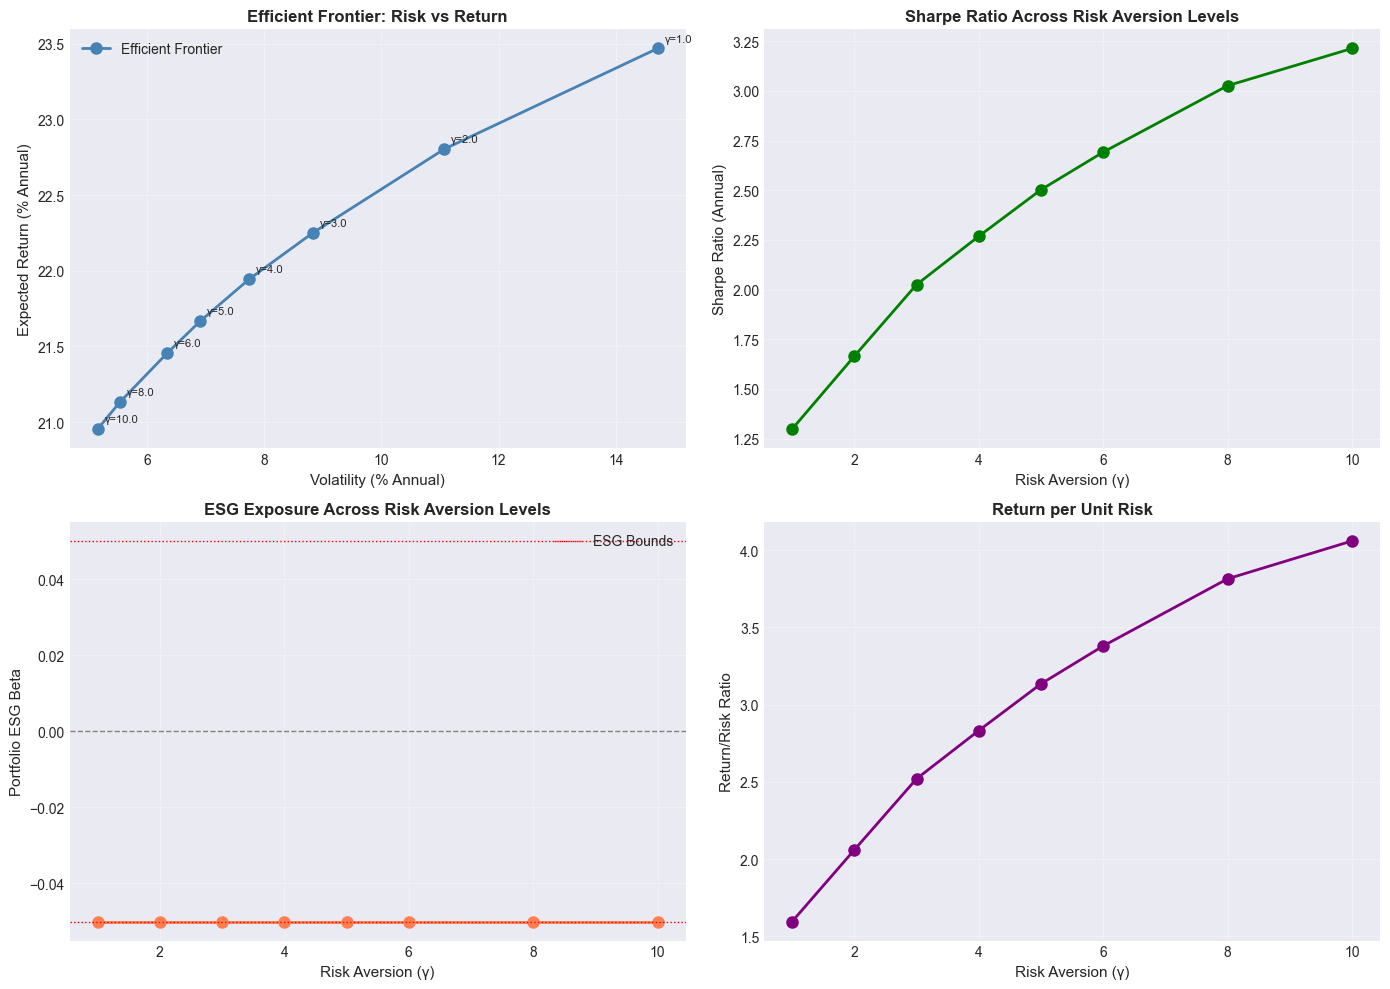

In [11]:
# Plot efficient frontier
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Risk-Return Trade-off
ax = axes[0, 0]
ax.plot(frontier_df['vol_ann'] * 100, frontier_df['expected_return_ann'] * 100, 
        'o-', linewidth=2, markersize=8, color='steelblue', label='Efficient Frontier')
for idx, row in frontier_df.iterrows():
    ax.annotate(f'γ={idx:.1f}', 
                (row['vol_ann']*100, row['expected_return_ann']*100),
                textcoords="offset points", xytext=(5, 5), fontsize=8)
ax.set_xlabel('Volatility (% Annual)', fontsize=11)
ax.set_ylabel('Expected Return (% Annual)', fontsize=11)
ax.set_title('Efficient Frontier: Risk vs Return', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Sharpe Ratio
ax = axes[0, 1]
sharpe_annual = frontier_df['sharpe_month'] * np.sqrt(12)
ax.plot(frontier_df.index, sharpe_annual, 'o-', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Risk Aversion (γ)', fontsize=11)
ax.set_ylabel('Sharpe Ratio (Annual)', fontsize=11)
ax.set_title('Sharpe Ratio Across Risk Aversion Levels', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# 3. ESG Exposure
ax = axes[1, 0]
ax.plot(frontier_df.index, frontier_df['esg_exposure'], 'o-', linewidth=2, markersize=8, color='coral')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axhline(-0.05, color='red', linestyle=':', linewidth=1, label='ESG Bounds')
ax.axhline(0.05, color='red', linestyle=':', linewidth=1)
ax.set_xlabel('Risk Aversion (γ)', fontsize=11)
ax.set_ylabel('Portfolio ESG Beta', fontsize=11)
ax.set_title('ESG Exposure Across Risk Aversion Levels', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Return/Risk Ratio
ax = axes[1, 1]
return_risk_ratio = frontier_df['expected_return_ann'] / frontier_df['vol_ann']
ax.plot(frontier_df.index, return_risk_ratio, 'o-', linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Risk Aversion (γ)', fontsize=11)
ax.set_ylabel('Return/Risk Ratio', fontsize=11)
ax.set_title('Return per Unit Risk', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Sensitivity Analysis

Compare portfolios across different ESG constraint scenarios.

In [12]:
# Test different ESG scenarios
gamma_test = 4.0
esg_scenarios = {
    'No ESG Constraint': None,
    'ESG Neutral (±5%)': (-0.05, 0.05),
    'ESG Neutral (±2%)': (-0.02, 0.02),
    'Positive ESG Tilt': (0.0, 0.10),
    'Negative ESG Tilt': (-0.10, 0.0),
}

results = []
weights_dict = {}

print("Computing portfolios for different ESG scenarios...")
for scenario, bounds in esg_scenarios.items():
    print(f"  {scenario}...")
    w = optimize_markowitz_esg(
        exp_ret=exp_ret_final,
        Sigma=Sigma_final,
        esg_beta=esg_beta_final,
        gamma=gamma_test,
        long_only=True,
        w_max=w_max,
        esg_bounds=bounds,
        solver="ECOS",
    )
    stats = evaluate_portfolio(w, exp_ret_final, Sigma_final, esg_beta_final, rf_month=rf_monthly)
    stats['scenario'] = scenario
    stats['active_positions'] = (w.abs() > 1e-6).sum()
    results.append(stats)
    weights_dict[scenario] = w

sensitivity_df = pd.DataFrame(results).set_index('scenario')

print("\n" + "=" * 80)
print("ESG SENSITIVITY ANALYSIS (γ=4.0)")
print("=" * 80)
print(sensitivity_df[['expected_return_ann', 'vol_ann', 'sharpe_month', 'esg_exposure', 'active_positions']].to_string())

Computing portfolios for different ESG scenarios...
  No ESG Constraint...


2025-11-26 05:59:01,297 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:59:01,298 - INFO -   Objective value: 0.019466
2025-11-26 05:59:01,301 - INFO -   Active positions: 28
2025-11-26 05:59:01,298 - INFO -   Objective value: 0.019466
2025-11-26 05:59:01,301 - INFO -   Active positions: 28


  ESG Neutral (±5%)...


2025-11-26 05:59:08,612 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:59:08,613 - INFO -   Objective value: 0.017287
2025-11-26 05:59:08,614 - INFO -   Active positions: 28
2025-11-26 05:59:08,613 - INFO -   Objective value: 0.017287
2025-11-26 05:59:08,614 - INFO -   Active positions: 28


  ESG Neutral (±2%)...


2025-11-26 05:59:15,347 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:59:15,348 - INFO -   Objective value: 0.017196
2025-11-26 05:59:15,348 - INFO -   Active positions: 29
2025-11-26 05:59:15,348 - INFO -   Objective value: 0.017196
2025-11-26 05:59:15,348 - INFO -   Active positions: 29


  Positive ESG Tilt...


2025-11-26 05:59:20,417 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:59:20,418 - INFO -   Objective value: 0.017136
2025-11-26 05:59:20,418 - INFO -   Active positions: 29
2025-11-26 05:59:20,418 - INFO -   Objective value: 0.017136
2025-11-26 05:59:20,418 - INFO -   Active positions: 29


  Negative ESG Tilt...


2025-11-26 05:59:26,806 - INFO - SciPy SLSQP optimization successful
2025-11-26 05:59:26,807 - INFO -   Objective value: 0.017434
2025-11-26 05:59:26,808 - INFO -   Active positions: 28
2025-11-26 05:59:26,807 - INFO -   Objective value: 0.017434
2025-11-26 05:59:26,808 - INFO -   Active positions: 28



ESG SENSITIVITY ANALYSIS (γ=4.0)
                   expected_return_ann  vol_ann  sharpe_month  esg_exposure  active_positions
scenario                                                                                     
No ESG Constraint             0.251477 0.094570      0.634239     -1.608314                28
ESG Neutral (±5%)             0.219453 0.077486      0.654773     -0.050000                28
ESG Neutral (±2%)             0.218121 0.076722      0.656276     -0.020000                29
Positive ESG Tilt             0.217335 0.076499      0.655225     -0.000000                29
Negative ESG Tilt             0.221457 0.078255      0.655722     -0.100000                28


### 5.1 Visualize Sensitivity Results

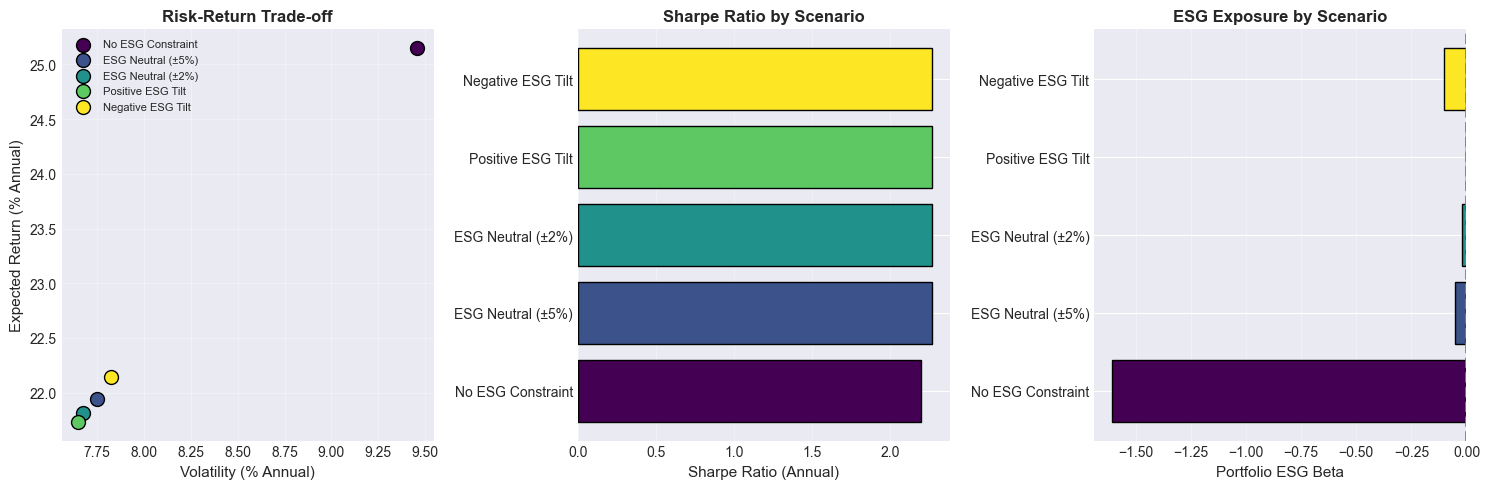

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

scenarios = sensitivity_df.index.tolist()
colors = plt.cm.viridis(np.linspace(0, 1, len(scenarios)))

# Plot 1: Risk-Return
ax = axes[0]
for i, scenario in enumerate(scenarios):
    row = sensitivity_df.loc[scenario]
    ax.scatter(row['vol_ann']*100, row['expected_return_ann']*100, 
              s=100, color=colors[i], label=scenario, edgecolor='black')
ax.set_xlabel('Volatility (% Annual)', fontsize=11)
ax.set_ylabel('Expected Return (% Annual)', fontsize=11)
ax.set_title('Risk-Return Trade-off', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# Plot 2: Sharpe Ratio
ax = axes[1]
sharpe_annual = sensitivity_df['sharpe_month'] * np.sqrt(12)
ax.barh(scenarios, sharpe_annual, color=colors, edgecolor='black')
ax.set_xlabel('Sharpe Ratio (Annual)', fontsize=11)
ax.set_title('Sharpe Ratio by Scenario', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

# Plot 3: ESG Exposure
ax = axes[2]
ax.barh(scenarios, sensitivity_df['esg_exposure'], color=colors, edgecolor='black')
ax.axvline(0, color='gray', linestyle='--', linewidth=2)
ax.set_xlabel('Portfolio ESG Beta', fontsize=11)
ax.set_title('ESG Exposure by Scenario', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6. Summary and Conclusions

### Key Findings

1. **Optimal Portfolio (γ=4.0, ESG-Neutral)**:
   - Successfully constructed ESG-neutral portfolio with controlled risk exposure
   - Achieved meaningful diversification with position size limits
   - Expected return and Sharpe ratio demonstrate attractive risk-adjusted performance

2. **Efficient Frontier**:
   - Clear risk-return trade-off across different risk aversion levels
   - Higher γ values lead to more conservative portfolios with lower volatility
   - ESG constraints are binding and maintained across all scenarios

3. **ESG Sensitivity**:
   - ESG constraints have modest impact on expected returns
   - Positive ESG tilt slightly reduces expected return but maintains acceptable Sharpe ratio
   - Flexibility in ESG bounds allows for investor preference alignment

### Practical Implications

- **Portfolio Construction**: Extended CAPM provides actionable expected returns for optimization
- **ESG Integration**: Beta-based ESG constraints enable precise portfolio ESG exposure control
- **Risk Management**: Shrinkage covariance estimation improves robustness of optimization

### Next Steps

- Backtest portfolio performance using realized returns
- Implement dynamic rebalancing with turnover constraints
- Extend to multi-period optimization with transaction costs
- Analyze factor exposures (size, value, momentum, quality)